# Apache Spark on Anaconda Python 3

© 2016 - Harald Schilly &lt;harald@schil.ly&gt; - CC BY-SA 4.0



### Configuration

* Anaconda Python 3 + scientific Python stack
* Apache Spark 1.6.1

`~/.zshrc`:

    export SPARK_HOME="/opt/spark/current/"
    export PYSPARK_SUBMIT_ARGS="--master local[*] pyspark-shell"
    export PATH="$PATH":$SPARK_HOME/bin
    export PYSPARK_PYTHON=/opt/anaconda/bin/python
    

`$SPARK_HOME/conf/spark-env.sh`:

    PYSPARK_DRIVER_PYTHON=ipython
    PYSPARK_DRIVER_PYTHON_OPTS=notebook
    
Start using: `$ pyspark`

http://localhost:4040

In [63]:
import sys
import os
import re
import numpy as np
import pandas as pd
from glob import glob
import operator

print(sys.version)

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set() # "talk")

3.5.1 |Anaconda 2.4.1 (64-bit)| (default, Dec  7 2015, 11:16:01) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


### Spark Kontext

In [64]:
sc, sqlContext

(<pyspark.context.SparkContext at 0x7f90492d71d0>,
 <pyspark.sql.context.SQLContext at 0x7f90262efe80>)

In [65]:
"Apache Spark Version %s" % sc.version

'Apache Spark Version 1.6.1'

### Values as parallelized vectors

In [66]:
values = sc.parallelize([3,5,2,3,1,5,2,3,2,3,1])
values

ParallelCollectionRDD[208] at parallelize at PythonRDD.scala:423

In [68]:
values.collect()

[3, 5, 2, 3, 1, 5, 2, 3, 2, 3, 1]

In [69]:
values.count()

11

### Plot a function

by mapping a range of values with a function

In [6]:
xx = sc.range(-200, 300)
xx

PythonRDD[2] at RDD at PythonRDD.scala:43

In [7]:
values_rdd = xx.map(lambda x : 2 * (x / 100)**2 - 10)

In [8]:
print(values_rdd.toDebugString().decode("utf8"))

(1) PythonRDD[3] at RDD at PythonRDD.scala:43 []
 |  ParallelCollectionRDD[1] at parallelize at PythonRDD.scala:423 []


In [9]:
yy = values_rdd.collect()

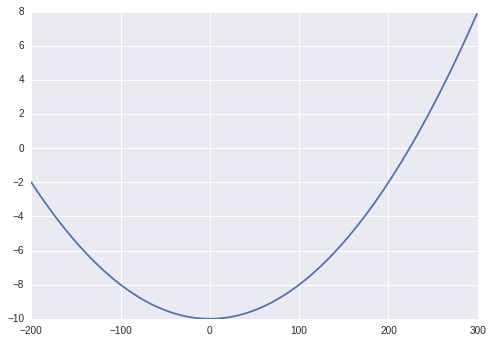

In [10]:
plt.plot(xx.collect(), yy)

## Broadcasting

Distribute the value to all workers in the cluster.

In [11]:
def get_words(f):
    x = f.zipWithIndex().filter(lambda x : 
            "Ende dieses Projekt Gutenberg Etextes" in x[0] or 
            "End of the Project Gutenberg EBook of Faust" in x[0]).first()[1]
    length = sc.broadcast(x)
    lines = f.zipWithIndex().filter(lambda x : x[1] > 40 and x[1] < length.value)
    return lines.flatMap(lambda x : x[0].split())

In [12]:
words = sc.emptyRDD()
for fn in glob("*.txt"):
    f = sc.textFile(fn, minPartitions=10)
    words = words.union(get_words(f))

In [13]:
print(words.toDebugString().decode("utf8"))

(20) UnionRDD[23] at union at NativeMethodAccessorImpl.java:-2 []
 |   UnionRDD[14] at union at NativeMethodAccessorImpl.java:-2 []
 |   PythonRDD[12] at RDD at PythonRDD.scala:43 []
 |   EmptyRDD[4] at emptyRDD at NativeMethodAccessorImpl.java:-2 []
 |   PythonRDD[13] at RDD at PythonRDD.scala:43 []
 |   goethe-faust2.txt MapPartitionsRDD[6] at textFile at NativeMethodAccessorImpl.java:-2 []
 |   goethe-faust2.txt HadoopRDD[5] at textFile at NativeMethodAccessorImpl.java:-2 []
 |   PythonRDD[22] at RDD at PythonRDD.scala:43 []
 |   goethe-faust1.txt MapPartitionsRDD[16] at textFile at NativeMethodAccessorImpl.java:-2 []
 |   goethe-faust1.txt HadoopRDD[15] at textFile at NativeMethodAccessorImpl.java:-2 []


In [14]:
words.count()

75971

In [15]:
# rough check, with header/footer:
!  cat *.txt | wc -w

82136


## Accumulators

Globale kommmutative Zählvariable.

In [16]:
chars = sc.accumulator(0)

In [17]:
words.foreach(lambda w : chars.add(len(w)))

In [18]:
chars.value

400674

In [19]:
# rough check, with header/footer:
!  cat *.txt | wc -c

574503


## Map/Reduce

Alle nicht-Buchstaben herausfiltern.

In [20]:
import re
pat = re.compile(r'[^a-zA-ZöäüÖÄÜß ]+', re.IGNORECASE)

In [70]:
wordtuples = words.map(lambda w : (pat.sub('', w), 1))
wordcounts = wordtuples.reduceByKey(lambda c1, c2 : c1 + c2)
wordcounts.takeOrdered(30, key = lambda x : -x[1])

[('und', 1264),
 ('ich', 1085),
 ('der', 1063),
 ('die', 1041),
 ('zu', 910),
 ('nicht', 874),
 ('Und', 822),
 ('sich', 732),
 ('ist', 667),
 ('ein', 626),
 ('das', 623),
 ('sie', 554),
 ('in', 542),
 ('es', 542),
 ('den', 498),
 ('Die', 496),
 ('du', 494),
 ('mich', 463),
 ('MEPHISTOPHELES', 442),
 ('mir', 437),
 ('so', 403),
 ('Ich', 396),
 ('er', 395),
 ('dem', 395),
 ('mit', 393),
 ('Das', 385),
 ('Der', 385),
 ('auf', 360),
 ('wie', 350),
 ('FAUST', 349)]

In [22]:
! cat *.txt | grep -c "MEPHISTOPHELES"

442


Kontrolle: Summe aller Wortlängen

In [23]:
from operator import add
wordcounts.map(lambda x : x[1]).reduce(add)

75971

## Längste Wörter

In [24]:
words.map(lambda w : (len(w), w)).top(10)

[(28, 'Untätigkeits-Entschuldigung:'),
 (28, 'Fettbauch-Krummbein-Schelme.'),
 (25, 'Kalenderei--Chymisterei--'),
 (25, 'Einsiedlerisch-beschränkt'),
 (25, 'Dreinamig-Dreigestaltete,'),
 (23, 'Schneckeschnickeschnack'),
 (22, 'allerliebst-geselliger'),
 (22, 'Flügelflatterschlagen!'),
 (22, 'Bürger-Nahrungs-Graus,'),
 (21, 'heimlich-kätzchenhaft')]

## Iterationen

In [25]:
x = 1000
words.cache()

UnionRDD[23] at union at NativeMethodAccessorImpl.java:-2

In [26]:
words_indexed = words.zipWithIndex().cache()

for i in range(20):
    d = 1 / (2 + i)
    v = words_indexed\
        .filter(lambda e : e[1] < x)\
        .map(lambda w : len(w[0])).reduce(operator.add)
    if v > 3000:
        x -= d * x
    else:
        x += d * x
    print("x[{:2d}] = {:9.2f} → v = {:d}    (d = {:.2f})".format(i, x, v, d))

x[ 0] =    500.00 → v = 5575    (d = 0.50)
x[ 1] =    666.67 → v = 2817    (d = 0.33)
x[ 2] =    500.00 → v = 3802    (d = 0.25)
x[ 3] =    600.00 → v = 2817    (d = 0.20)
x[ 4] =    500.00 → v = 3429    (d = 0.17)
x[ 5] =    571.43 → v = 2817    (d = 0.14)
x[ 6] =    500.00 → v = 3239    (d = 0.12)
x[ 7] =    555.56 → v = 2817    (d = 0.11)
x[ 8] =    500.00 → v = 3154    (d = 0.10)
x[ 9] =    545.45 → v = 2817    (d = 0.09)
x[10] =    500.00 → v = 3094    (d = 0.08)
x[11] =    538.46 → v = 2822    (d = 0.08)
x[12] =    500.00 → v = 3049    (d = 0.07)
x[13] =    533.33 → v = 2822    (d = 0.07)
x[14] =    500.00 → v = 3022    (d = 0.06)
x[15] =    529.41 → v = 2822    (d = 0.06)
x[16] =    500.00 → v = 3001    (d = 0.06)
x[17] =    526.32 → v = 2822    (d = 0.05)
x[18] =    552.63 → v = 2988    (d = 0.05)
x[19] =    526.32 → v = 3130    (d = 0.05)


## PageRank

siehe [spark-pagerank.ipynb](spark-pagerank.ipynb)

In [27]:
link_data = [
    (0, 1),
    (0, 2),
    (0, 3),
    (1, 3),
    (1, 3),
    (2, 3),
    (3, 0),
    (4, 0),
    (2, 3),
    (4, 1)
]

In [28]:
links = sc.parallelize(link_data).distinct().groupByKey().cache()

In [29]:
# init rank data
ranks = links.map(lambda l: (l[0], 1.0))

In [30]:
from operator import add

def computeContribs(urls, rank):
    num_urls = len(urls)
    for url in urls:
        yield url, rank / num_urls

for iteration in range(10):
    # Calculates contribution of link to neighbour
    contribs = links.join(ranks)\
        .flatMap(lambda url_urls_rank: computeContribs(*url_urls_rank[1]))

    # Re-calculates URL ranks based on neighbor contributions.
    ranks = contribs.reduceByKey(add).mapValues(lambda rank: rank * 0.85 + 0.15)

# Collects all URL ranks and dump them to console.
for (link, rank) in sorted(ranks.collect()):
    print("%s has rank: %s." % (link, rank))

0 has rank: 1.4925426310288215.
1 has rank: 0.569011704714285.
2 has rank: 0.569011704714285.
3 has rank: 1.5663083638833293.


## Histogram

In [31]:
import string
U = string.ascii_uppercase

In [32]:
chars = words.flatMap(lambda x : list(x)) \
    .map(lambda c : c.upper()) \
    .filter(lambda c : c in string.ascii_uppercase)
chars.cache()
print(chars.collect()[:100])

['F', 'A', 'U', 'S', 'T', 'D', 'E', 'R', 'T', 'R', 'A', 'G', 'D', 'I', 'E', 'Z', 'W', 'E', 'I', 'T', 'E', 'R', 'T', 'E', 'I', 'L', 'V', 'O', 'N', 'J', 'O', 'H', 'A', 'N', 'N', 'W', 'O', 'L', 'F', 'G', 'A', 'N', 'G', 'V', 'O', 'N', 'G', 'O', 'E', 'T', 'H', 'E', 'A', 'N', 'M', 'U', 'T', 'I', 'G', 'E', 'G', 'E', 'G', 'E', 'N', 'D', 'H', 'O', 'C', 'H', 'G', 'E', 'W', 'L', 'B', 'T', 'E', 'S', 'E', 'N', 'G', 'E', 'S', 'G', 'O', 'T', 'I', 'S', 'C', 'H', 'E', 'S', 'Z', 'I', 'M', 'M', 'E', 'R', 'V', 'O']


In [33]:
char_freq = chars.countByKey()
char_freq

defaultdict(int,
            {'A': 18156,
             'B': 6805,
             'C': 14955,
             'D': 17899,
             'E': 58860,
             'F': 6385,
             'G': 11132,
             'H': 24159,
             'I': 30167,
             'J': 712,
             'K': 4438,
             'L': 15773,
             'M': 11007,
             'N': 35768,
             'O': 8644,
             'P': 3231,
             'Q': 134,
             'R': 25718,
             'S': 25371,
             'T': 23848,
             'U': 14859,
             'V': 2613,
             'W': 7172,
             'X': 97,
             'Y': 199,
             'Z': 4197})

[]

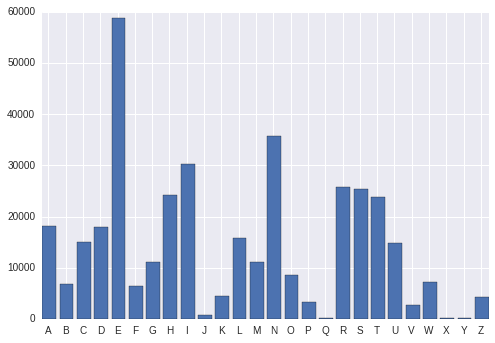

In [34]:
fig,ax = plt.subplots()
_ = ax.bar(range(len(U)), [char_freq[_] for _ in U])
_ = ax.set_xticks(np.arange(len(U)) + .35)
_ = ax.set_xticklabels(U)
plt.plot()


# Lineare Regression

Zufällige Daten generieren …

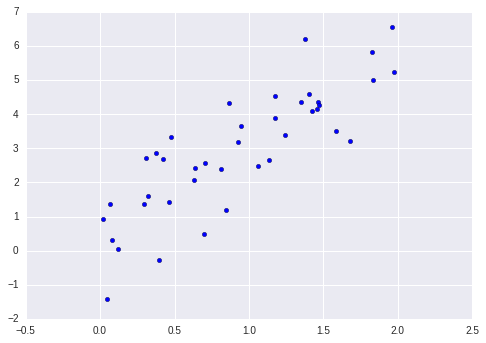

In [35]:
data = np.c_[
    sorted(2 * np.random.rand(40)),
    np.r_[np.random.randn(20) + np.linspace(0, 3, 20),
          np.random.randn(20) + np.linspace(0, 2, 20) + 3]
]
plt.scatter(data[:,0], data[:,1])

In [36]:
from pyspark.mllib.regression import LabeledPoint, LinearRegressionWithSGD

Datenpunkte und dazugehöriger Featurevektor (exogen x → endogen y)

In [37]:
sparkdata = sc.parallelize(LabeledPoint(y, [x]) for x, y in data)

In [38]:
lm = LinearRegressionWithSGD.train(sparkdata)
lm

(weights=[3.0204407579], intercept=0.0)

In [39]:
valuesAndPreds = sparkdata.map(lambda p: (p.label, lm.predict(p.features)))
MSE = valuesAndPreds.map(lambda v_p: (v_p[0] - v_p[1])**2).sum() / valuesAndPreds.count()
print("Mean Squared Error = " + str(MSE))

Mean Squared Error = 1.02845039572


In [40]:
xx = np.linspace(-1, 3, 100)
yy = [lm.predict([_]) for _ in xx]

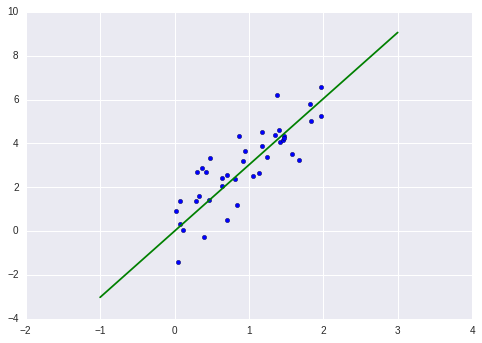

In [41]:
fig, ax = plt.subplots()
_ = ax.scatter(data[:,0], data[:,1])
_ = ax.plot(xx, yy, color="green")
plt.show()

# Isotonic Regression

[pyspark.mllib.IsotonicRegression](https://spark.apache.org/docs/latest/mllib-isotonic-regression.html)

In [42]:
from pyspark.mllib.regression import IsotonicRegression

In [43]:
sparkiso = sc.parallelize((y, x, 1) for x, y in data)

In [44]:
ir = IsotonicRegression.train(sparkiso)

In [45]:
valuesAndPreds2 = sparkdata.map(lambda p: (p.label, ir.predict(p.features)))
MSE = valuesAndPreds2.map(lambda v_p: (v_p[0] - v_p[1])**2).sum() / valuesAndPreds2.count()
print("Mean Squared Error = " + str(MSE))

Mean Squared Error = [ 0.64607526]


In [46]:
yy2 = [ir.predict([_]) for _ in xx]

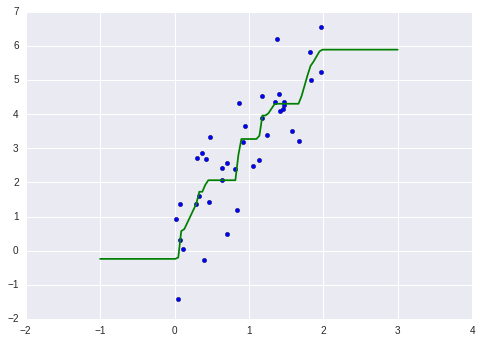

In [47]:
fig, ax = plt.subplots()
_ = ax.scatter(data[:,0], data[:,1])
_ = ax.plot(xx, yy2, color="green")
plt.show()

## DataFrames

http://spark.apache.org/docs/latest/sql-programming-guide.html

In [48]:
from pyspark.sql import SQLContext, Row
sqlContext = SQLContext(sc)

In [49]:
entries = sc.textFile("elements.csv").map(lambda line : line.split(","))
print(', '.join(entries.first()))

Electronegativity,  Calculated Radius,  First Ionization,  Core Configuration,  Heat of Vapor,  Covalent Radius,  Heat of Fusion,  Bulk Modulus,  Boiling Point,  Brinell Hardness,  Melting Point,  Symbol,  STP Density,  Young Modulus,  Shear Modulus,  Vickers Hardness,  Name,  Common Ions,  Second Ionization,  Mass,  Van der Waals Radius,  Specific Heat,  Thermal Cond.,  Third Ionization,  Series,  Electron Affinity,  Atomic Number,  Mohs Hardness,  Empirical Radius


Converting second to last row into "Row"s

In [52]:
def try_float(x):
    try:
        return float(x)
    except:
        np.nan

elements = entries.zipWithIndex()\
    .filter(lambda x : x[1] >= 1).map(lambda x : x[0]) \
    .map(lambda e: Row(
        number = int(e[-3]),
        symbol = e[11],
        name   = e[16],
        mass   = try_float(e[19]),
        radius = try_float(e[-1])
    ))

registering Schema

In [54]:
elementsDF = sqlContext.createDataFrame(elements)
elementsDF.registerTempTable("elements")

Ausgabe der Tabelle

In [55]:
elementsDF.show()

+----------+----------+------+------+------+
|      mass|      name|number|radius|symbol|
+----------+----------+------+------+------+
|   1.00794|  Hydrogen|     1|  25.0|     H|
|  4.002602|    Helium|     2|  null|    He|
|     6.941|   Lithium|     3| 145.0|    Li|
|  9.012182| Beryllium|     4| 105.0|    Be|
|    10.811|     Boron|     5|  85.0|     B|
|    2352.6|    Carbon|     6|  70.0|     C|
|   14.0067|  Nitrogen|     7|  65.0|     N|
|   15.9994|    Oxygen|     8|  60.0|     O|
|18.9984032|  Fluorine|     9|  50.0|     F|
|   20.1797|      Neon|    10|  null|    Ne|
|   22.9898|    Sodium|    11| 180.0|    Na|
|    24.305| Magnesium|    12| 150.0|    Mg|
|   26.9815|  Aluminum|    13| 125.0|    Al|
|   28.0855|   Silicon|    14| 110.0|    Si|
|   30.9738|Phosphorus|    15| 100.0|     P|
|    32.065|    Sulfur|    16| 100.0|     S|
|    35.453|  Chlorine|    17| 100.0|    Cl|
|    39.948|     Argon|    18|  71.0|    Ar|
|   39.0983| Potassium|    19| 220.0|     K|
|    40.07

Registering Schema

In [56]:
elementsDF = sqlContext.createDataFrame(elements)
elementsDF.registerTempTable("elements")

Inferring types

In [57]:
elementsDF.printSchema()

root
 |-- mass: double (nullable = true)
 |-- name: string (nullable = true)
 |-- number: long (nullable = true)
 |-- radius: double (nullable = true)
 |-- symbol: string (nullable = true)



Query DataFrame with SQL

In [58]:
heavy = sqlContext.sql("SELECT number, name, mass FROM elements WHERE mass >= 250 SORT BY number")
heavy.collect()

[Row(number=6, name='Carbon', mass=2352.6),
 Row(number=22, name='Titanium', mass=1309.8),
 Row(number=24, name='Chromium', mass=1590.6),
 Row(number=26, name='Iron', mass=1561.9),
 Row(number=27, name='Cobalt', mass=1648.0),
 Row(number=29, name='Copper', mass=1957.9),
 Row(number=50, name='Tin', mass=1411.8),
 Row(number=58, name='Cerium', mass=1050.0),
 Row(number=79, name='Gold', mass=1980.0),
 Row(number=80, name='Mercury', mass=1810.0),
 Row(number=81, name='Thallium', mass=1971.0),
 Row(number=82, name='Lead', mass=1450.5)]

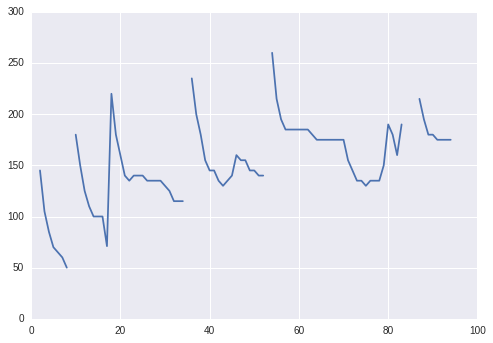

In [59]:
radii = sqlContext.sql("SELECT radius FROM elements SORT BY number")
plt.plot(radii.collect())

Query DataFrame

In [60]:
df = elementsDF.select('number', 'name', 'radius', 'mass')\
    .filter(elementsDF.mass < 20)\
    .sort('number')
df.show()

+------+---------+------+----------+
|number|     name|radius|      mass|
+------+---------+------+----------+
|     1| Hydrogen|  25.0|   1.00794|
|     2|   Helium|  null|  4.002602|
|     3|  Lithium| 145.0|     6.941|
|     4|Beryllium| 105.0|  9.012182|
|     5|    Boron|  85.0|    10.811|
|     7| Nitrogen|  65.0|   14.0067|
|     8|   Oxygen|  60.0|   15.9994|
|     9| Fluorine|  50.0|18.9984032|
+------+---------+------+----------+



In [61]:
df.fillna(0).show()

+------+---------+------+----------+
|number|     name|radius|      mass|
+------+---------+------+----------+
|     1| Hydrogen|  25.0|   1.00794|
|     2|   Helium|   0.0|  4.002602|
|     3|  Lithium| 145.0|     6.941|
|     4|Beryllium| 105.0|  9.012182|
|     5|    Boron|  85.0|    10.811|
|     7| Nitrogen|  65.0|   14.0067|
|     8|   Oxygen|  60.0|   15.9994|
|     9| Fluorine|  50.0|18.9984032|
+------+---------+------+----------+



Future: Spark 2.0 hat [DataSets](https://databricks.com/blog/2016/01/04/introducing-spark-datasets.html)